# CS 109A/AC 209A/STAT 121A Data Science: PROJECT
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

Import libraries

In [2]:
import numpy as np
import pandas as pd
import scipy as splogreg
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
#from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split as sk_split
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from datetime import datetime
from dateutil import parser, relativedelta
%matplotlib inline

In [3]:
print datetime.now()

2016-12-12 21:48:58.993000


--------------

In [4]:
# some conversion functions
to_datetime = lambda d: datetime.strptime(d, '%b-%Y')
pct_to_float = lambda s: float(s.strip('%'))/100.00

In [5]:
# load the data in, convert issue_d to a datetime field
base_folder = 'data/'
file_name = 'LoanStats3b.csv' # 3b = 2012/2013
df_file = pd.read_csv(base_folder+file_name, delimiter=',', converters={'issue_d': to_datetime})
df_file.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10159611,12011228,10000,10000,10000,36 months,9.67%,321.13,B,B1,...,0,1,77.3,66.7,0,0,58486,39143,9200,36186
1,10129477,11981093,14000,14000,14000,36 months,12.85%,470.71,B,B4,...,0,0,78.6,100.0,1,0,31840,17672,3900,27340
2,10149342,12000897,27050,27050,27050,36 months,10.99%,885.46,B,B2,...,0,1,100.0,25.0,0,0,138554,70186,35700,33054
3,10139658,11991209,12000,12000,12000,36 months,13.53%,407.40,B,B5,...,0,2,81.2,33.3,0,0,18130,13605,7000,10030
4,10159548,12011167,15000,15000,15000,36 months,8.90%,476.30,A,A5,...,0,0,89.3,66.7,0,0,288195,39448,14200,33895


For a more detailed exploration of the various variables, see also <a href="http://oweng.net/LendingClub/sample_data.html">sample data</a>.

In [6]:

print 'The full file we have chosen, covering loans issued in 2012 and 2013 has {:,} rows and {} columns.'.format(
            df_file.shape[0],  df_file.shape[1]) # (188181, 111)

# function to create a single binary value that indicates whether or not a loan was paid off
def default_status(status):
    default_val = -1
    if status in ('Charged Off','Default'):
        default_val = 1
    elif status == 'Fully Paid':
        default_val = 0
        
    return default_val
    

# add defaulted column, 1 for those that defaulted, 0 for those that paid (-1 for all others)
df_file['defaulted'] = df_file['loan_status'].apply(lambda s: default_status(s))
# only want loans that have ended definitively
df_file = df_file[df_file['defaulted'] > -1 ]

print 'After culling down to only those loans that have ended, wind up with {:,} rows.'.format(df_file.shape[0])



The full file we have chosen, covering loans issued in 2012 and 2013 has 188,181 rows and 111 columns.
After culling down to only those loans that have ended, wind up with 159,060 rows.


In [7]:
# create a new column that holds only the year value for when the loan was issued
df_file['year'] = df_file['issue_d'].apply(lambda dt: dt.year)

print 'Loan counts broken out by issue year:'
print df_file['year'].value_counts()

print 'and broken out additionally by loan term and default status'
df_file.groupby(['year', 'term', 'defaulted']).size()

Loan counts broken out by issue year:
2013    108332
2012     50728
dtype: int64
and broken out additionally by loan term and default status


year  term        defaulted
2012   36 months  0            37564
                  1             5906
       60 months  0             4750
                  1             2508
2013   36 months  0            76684
                  1            11898
       60 months  0            13384
                  1             6366
dtype: int64

In [8]:
# trying to settle on a reasonable number of rows, want a lot of data of course but we
# will also be constrained by the computing power of our local machines
# Narrowing to all 3-year loans issued in 2013 seems a good compromise
df_subset = df_file[(df_file['year']==2013) & (df_file['term']==' 36 months')]
df_subset.is_copy = False

print 'Narrow down to only 3-year loans issued in 2013, left with {:,} rows.'.format(df_subset.shape[0])

Narrow down to only 3-year loans issued in 2013, left with 88,582 rows.


In [9]:
# create rubric for scoring the cost of having someone to whom a loan has been issued ultimately default on full repayment
def cost_of_default(row):
    cost = 0
    if row['defaulted'] == 1:
        # amount lent - how much was paid before the loan defaulted - cost of collecting unpaid amount
        cost = row['loan_amnt'] - row['total_pymnt'] - row['collection_recovery_fee']
        
    return cost
    
    
df_subset['default_cost'] = df_subset.apply(lambda row: cost_of_default(row), axis=1)


In [10]:
# now set the initial df object, this makes it easier to reset while working on subsequent code
df = df_subset
df.is_copy = False

-----------

In [11]:
print 'Summary stats of numerical data, depending on the subset of data under review, there appear to be quite a few '
print 'columns that are entirely empty. These will be proactively removed from the data before modeling.'
print 'In fact, these stats can also be used when trying to decide which time range of data to review, some values may'
print 'precipitously increase or decrease, which in turn can have different ripple effects in different model scenarios.'
print
print

fmt = '{:<30}{:<10}{:<10}{:>12}{:>20}{:>20}'
fmt_numbers = '{:<30}{:<10}{:<10}{:>12,.4f}{:>20,.4f}{:>20,.4f}'
    
print fmt.format('', 'missing', 'missing', '', '', '')
print fmt.format('column', 'ALL?', 'ANY?', 'min', 'max', 'mean')
print '-----------------------------------------------------------------------------------------------------------------'
alpha_dtypes = sorted(df.dtypes.iteritems(), key = lambda item: item[0])

numeric_count = 0
non_numeric_count = 0
empty_columns = []
fully_pop_columns = []
for col, data_type in alpha_dtypes:
    if col == 'member_id':
        non_numeric_count += 1
        fully_pop_columns.append(col)
        continue

    all_empty = df[col].isnull().values.all()
    any_empty = df[col].isnull().values.any()
    if data_type == np.int64 or data_type == np.float64:
        numeric_count += 1
        if all_empty:
            empty_columns.append(col)
            min_val, max_val, mean_val = 'n.a.','n.a.','n.a'
            line = fmt.format(col, str(all_empty), str(any_empty), min_val, max_val, mean_val)
        else:
            #print data_type
            stats = df[col].describe()            
            min_val, max_val, mean_val = stats['min'], stats['max'], stats['mean']
            line = fmt_numbers.format(col, str(all_empty), str(any_empty), min_val, max_val, mean_val)
        print line
    else:
        non_numeric_count += 1
        if all_empty:
            empty_columns.append(col)
    if not any_empty:
        fully_pop_columns.append(col)
            
            
print            
print '{} numeric columns summarized'.format(numeric_count)
print '{} non-numeric columns skipped'.format(non_numeric_count)
print

print '{} empty columns to be dropped:'.format(len(empty_columns))
print '\t' + ', '.join(empty_columns)
print '{} columns are fully populated:'.format(len(fully_pop_columns))
print '\t' + ', '.join(fully_pop_columns)


Summary stats of numerical data, depending on the subset of data under review, there appear to be quite a few 
columns that are entirely empty. These will be proactively removed from the data before modeling.
In fact, these stats can also be used when trying to decide which time range of data to review, some values may
precipitously increase or decrease, which in turn can have different ripple effects in different model scenarios.


                              missing   missing                                                       
column                        ALL?      ANY?               min                 max                mean
-----------------------------------------------------------------------------------------------------------------
acc_now_delinq                False     False           0.0000              5.0000              0.0031
acc_open_past_24mths          False     False           0.0000             31.0000              3.9075
all_util                      True   

In [12]:
# drop all the columns that are entirely empty
print 'we begin with {} columns'.format(df.shape[1])
columns_to_drop = list(set(df.columns).intersection(set(empty_columns)))
df.drop(columns_to_drop, axis=1, inplace=True)
print '... and after those that are entirely empty the dataset is down to {} columns'.format(df.shape)


we begin with 114 columns
... and after those that are entirely empty the dataset is down to (88582, 97) columns


In [13]:
print 'of those not fully populated, how many observations are empty and what is the proportion of missing data? '

df_count = pd.DataFrame(df.drop(fully_pop_columns, axis=1).count())
df_count['missing_prop'] = df_count.apply(lambda cnt: 1-(cnt*1.0/df.shape[0]))
df_count

of those not fully populated, how many observations are empty and what is the proportion of missing data? 


,0,missing_prop
emp_title,82584,0.067711
desc,33216,0.625025
title,88578,0.000045
mths_since_last_delinq,38218,0.568558
mths_since_last_record,11201,0.873552
revol_util,88533,0.000553
last_pymnt_d,88502,0.000903
next_pymnt_d,18,0.999797
last_credit_pull_d,88575,0.000079
mths_since_last_major_derog,18119,0.795455


In [14]:
# a list of those missing some data: the field, recommended action, description from data dictionary

some_missing = [('emp_title','drop','title supplied by borrower'),
('desc','drop','loan description supplied by borrower'),
('title','drop','loan title supplied by borrower'),
('mths_since_last_delinq','zero-fill','# of months since borrower''s last delinquency'),
('mths_since_last_record','zero-fill','months since last public record'),
('revol_util','zero-fill','amount of credit borrower is using relative to all available revolving credit'),
('last_pymnt_d','drop','last month payment was received'),
('next_pymnt_d','drop','next scheduled payment date'),
('last_credit_pull_d','drop','last month LC pulled credit for this loan'),
('mths_since_last_major_derog','zero-fill','months since most recent 90-day or worse rating'),
('avg_cur_bal','zero-fill','average current balance of all accounts'),
('bc_open_to_buy','zero-fill','total open to buy on revolving bankcards'),
('bc_util','zero-fill','ratio of total curr balance to high credit/credit limit for all bankcard accnts'),
('mo_sin_old_il_acct','zero-fill','months since oldest bank installment account opened'),
('mths_since_recent_bc','zero-fill','months since most recent bankcard account opened'),
('mths_since_recent_bc_dlq','zero-fill','months since most recent bankcard delinquency'),
('mths_since_recent_inq','zero-fill','months since most recent inquiry'),
('mths_since_recent_revol_delinq','zero-fill','months since most recent revolving delinquency'),
('num_tl_120dpd_2m','zero-fill','number of accounts currently 120 days past due (updated in past 2 months)'),
('pct_tl_nvr_dlq','zero-fill','percent of trades never delinquent'),
('percent_bc_gt_75','zero-fill','percentage of all bankcard accounts > 75% of limit')]

print 'preliminary review of those missing some data results in a series of actions'
print
print '{:<32}{:<12}{}'.format('column','action','description')
print '-'*100
for col, action, descr in some_missing:
    print '{:<32}{:<12}{}'.format(col, action, descr)

preliminary review of those missing some data results in a series of actions

column                          action      description
----------------------------------------------------------------------------------------------------
emp_title                       drop        title supplied by borrower
desc                            drop        loan description supplied by borrower
title                           drop        loan title supplied by borrower
mths_since_last_delinq          zero-fill   # of months since borrowers last delinquency
mths_since_last_record          zero-fill   months since last public record
revol_util                      zero-fill   amount of credit borrower is using relative to all available revolving credit
last_pymnt_d                    drop        last month payment was received
next_pymnt_d                    drop        next scheduled payment date
last_credit_pull_d              drop        last month LC pulled credit for this loan
mths_since_last

In [15]:
print 'take a look at columns that are to be filled'
# everything in the some_missing list is either destined to be dropped or have missing values filled in
cols_to_fill = [col for col,action,descr in some_missing if action <> 'drop']
df[cols_to_fill].head(10)

take a look at columns that are to be filled


,mths_since_last_delinq,mths_since_last_record,revol_util,mths_since_last_major_derog,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_tl_120dpd_2m,pct_tl_nvr_dlq,percent_bc_gt_75
2,NaN,NaN,61.2%,NaN,9570,16473,53.9,117,16,NaN,8,NaN,0,100.0,25.0
3,53,33,68.8%,53,2268,1428,79.6,124,11,53,17,53,0,81.2,33.3
9,64,NaN,54.5%,71,869,6811,54.6,115,0,70,0,70,0,90.2,50.0
10,58,53,54.2%,69,3906,2050,52.3,164,14,69,8,69,0,91.3,66.7
11,NaN,NaN,55.7%,NaN,11783,2441,83.5,123,10,NaN,10,NaN,0,100.0,100.0
12,NaN,NaN,54.6%,NaN,53306,13901,67.1,125,5,NaN,3,NaN,0,100.0,16.7
14,16,NaN,66.2%,16,39267,1016,74.6,NaN,11,35,11,35,0,75.0,50.0
15,NaN,NaN,76.7%,NaN,15372,4822,77.6,179,18,NaN,7,NaN,0,100.0,75.0
16,NaN,104,34.6%,NaN,1772,2255,72.5,129,18,NaN,6,NaN,0,100.0,75.0
18,NaN,NaN,22.3%,NaN,815,15051,27.6,2,7,NaN,2,NaN,0,100.0,7.7


In [16]:
# gather other columns that we wan to drop

# all of the below rate to information gathered during the term of the loan and do not represent information available 
later_info = [('out_prncp', 'Remaining outstanding principal for total amount funded'),
('out_prncp_inv', 'Remaining outstanding principal for portion of total amount funded by investors'),
# keep this one for now, will be useful in predicted cost of incorrectly guessing default status
#('total_pymnt', 'Payments received to date for total amount funded'),
('total_pymnt_inv', 'Payments received to date for portion of total amount funded by investors'),
('total_rec_prncp', 'Principal received to date'),
('total_rec_int', 'Interest received to date'),
('total_rec_late_fee', 'Late fees received to date'),
('recoveries', 'post charge off gross recovery'),
('collection_recovery_fee', 'post charge off collection fee'),
('last_pymnt_amnt', 'Last total payment amount received')]

print 'Below are one set of columns to drop, those that appear to reflect information unavailable at the time loan was issued.'
print 'There may be additional columns that fall under this umbrella but best we can do is use logic to determine.'
print
print '{:<35}{}'.format('column','description')
print '-'*100
for col, descr in later_info:
    print '{:35}{}'.format(col, descr)

Below are one set of columns to drop, those that appear to reflect information unavailable at the time loan was issued.
There may be additional columns that fall under this umbrella but best we can do is use logic to determine.

column                             description
----------------------------------------------------------------------------------------------------
out_prncp                          Remaining outstanding principal for total amount funded
out_prncp_inv                      Remaining outstanding principal for portion of total amount funded by investors
total_pymnt_inv                    Payments received to date for portion of total amount funded by investors
total_rec_prncp                    Principal received to date
total_rec_int                      Interest received to date
total_rec_late_fee                 Late fees received to date
recoveries                         post charge off gross recovery
collection_recovery_fee            post charge off collec

In [17]:
            
later_info_cols =  [col for col,descr in later_info]

# drop the ones that hold our y values or equivalent... actually just drop loan_status now, so that it doesn't get one-hot
# y_type_info_cols = ['defaulted', 'loan_status', 'default_cost']
y_type_info_cols = ['loan_status']
    
# drop some more other reasons
# url = URL for the LC page with listing data.
# grade = LC assigned loan grade, we are keeping subgrade which effectively includes the grade info
# pymnt_plan = is 'n' for all rows
# year = a column we added, will be 2013 for all rows
# term = we have already filtered to 3-year loans, value is 36 months for all
# policy_code = is 1 for all our filtered rows
others_to_drop_cols = ['url', 'grade', 'pymnt_plan', 'year', 'term', 'policy_code' ]

print 'Dropping more columns for variety of reasons, including ones whose information is already contained in other columns:'
print y_type_info_cols[0]
print '\n'.join(others_to_drop_cols)


Dropping more columns for variety of reasons, including ones whose information is already contained in other columns:
loan_status
url
grade
pymnt_plan
year
term
policy_code


In [18]:
# now to drop the ones with some missing data, either
# a) are textual columns, maybe we can come back and codify columns as binary or something. e.g. 0 if they filled in the 
#    emp_title column, we'll see
# b) aren't relevant to prediction, these are all closed loans, payment dates and credit pulls (some of which are dated 
#    in 2016, can't be used to predict
cols_to_drop = [col for col,action,descr in some_missing if action == 'drop']
cols_to_drop += later_info_cols + others_to_drop_cols + y_type_info_cols
x_df = df.drop(cols_to_drop, axis=1)
print 'dropped columns: {}'.format(', '.join(cols_to_drop))
print
print 'Remaining data:'
x_df.head()

dropped columns: emp_title, desc, title, last_pymnt_d, next_pymnt_d, last_credit_pull_d, out_prncp, out_prncp_inv, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_amnt, url, grade, pymnt_plan, year, term, policy_code, loan_status

Remaining data:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,sub_grade,emp_length,home_ownership,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,defaulted,default_cost
2,10149342,12000897,27050,27050,27050,10.99%,885.46,B2,10+ years,OWN,...,100.0,25.0,0,0,138554,70186,35700,33054,0,0
3,10139658,11991209,12000,12000,12000,13.53%,407.40,B5,10+ years,RENT,...,81.2,33.3,0,0,18130,13605,7000,10030,0,0
9,10129506,11981122,20800,20800,20800,13.53%,706.16,B5,10+ years,RENT,...,90.2,50.0,0,0,43100,23473,15000,0,0,0
10,10179520,12031088,3000,3000,3000,12.85%,100.87,B4,10+ years,RENT,...,91.3,66.7,2,0,32082,19530,4300,26782,0,0
11,10148122,11999781,12000,12000,12000,7.62%,373.94,A3,3 years,MORTGAGE,...,100.0,100.0,0,0,233004,46738,14800,53404,0,0


In [19]:
print 'zero-fill the revol_util column, confirm contents of column'
# fill 'revol_util' - of the ones to "zero-fill", this appears to be only one that isn't strictly numerical
revol = x_df['revol_util'].fillna('0%')
revol = revol.apply(pct_to_float)

x_df = x_df.drop('revol_util', axis=1)
x_df = x_df.join(revol)

x_df['revol_util'].head()

zero-fill the revol_util column, confirm contents of column


2     0.612
3     0.688
9     0.545
10    0.542
11    0.557
Name: revol_util, dtype: float64

In [20]:
print 'int_rate/Interest Rate is being stored as a string, with % sign, turn those into float values'
# convert int_rate/interest rate into numerical, from string with trailing %
rate = x_df['int_rate']
rate = rate.apply(pct_to_float)

x_df = x_df.drop('int_rate', axis=1)
x_df = x_df.join(rate)

x_df['int_rate'].head()

int_rate/Interest Rate is being stored as a string, with % sign, turn those into float values


2     0.1099
3     0.1353
9     0.1353
10    0.1285
11    0.0762
Name: int_rate, dtype: float64

In [21]:
print 'In anticipation of one-hot encoding, want to convert any categorical values into numerical ones, where that is '
print ' appropriate. The sub_grade column is one of those, since it is essentially an ordinal value.'
# sub_grade values are ordinal, safe to convert into number equivalents, e.g. 'A1': 0, 'C3': 12
subgrades = ['{}{}'.format(l, i) for l in 'ABCDEFG' for i in range(1,6)]
subgrade_map = dict(zip(subgrades, range(len(subgrades))))

subgrade = x_df['sub_grade']
subgrade = subgrade.apply(lambda val: subgrade_map[val])
x_df = x_df.drop('sub_grade', axis=1)
x_df = x_df.join(subgrade)

x_df['sub_grade'].head()

In anticipation of one-hot encoding, want to convert any categorical values into numerical ones, where that is 
 appropriate. The sub_grade column is one of those, since it is essentially an ordinal value.


2     6
3     9
9     9
10    8
11    2
Name: sub_grade, dtype: int64

In [22]:
print 'earliest_cr_line is another column that can be converted from a string value into an a number, in this case '
print ' the number of months prior to January, 2014.'

# convert date string like 'Sep-2010' into a numerical, number of months since a basis date
# x_df['earliest_cr_line'].min() # 'Apr-1955' is oldest value in here
# x_df['earliest_cr_line'].max() # 'Sep-2010' is latest

def mth_year_to_months(d):
    # 'Sep-2010' to number of months since January 2014
    diff = relativedelta.relativedelta(datetime(2014,1,1), parser.parse(d))
    return diff.years * 12 + diff.months

x_df['earliest_cr_line'] = x_df['earliest_cr_line'].apply(lambda ecl: mth_year_to_months(ecl))

x_df['earliest_cr_line'].head()

earliest_cr_line is another column that can be converted from a string value into an a number, in this case 
 the number of months prior to January, 2014.


2     326
3     182
9     186
10    271
11    123
Name: earliest_cr_line, dtype: int64

In [23]:
print 'Filling in any remaining missing values, confirm success.'
# of the remaining to fill, using zero is appropriate value

x_df = x_df.replace(np.nan, 0)
#x_df[cols_to_fill].head()
print 'Anything nully remaining?: {}'.format(x_df.isnull().values.any())


Filling in any remaining missing values, confirm success.
Anything nully remaining?: False


In [24]:
'Data check, now down to {} columns for the {:,} rows'.format(x_df.shape[1], x_df.shape[0])

'Data check, now down to 75 columns for the 88,582 rows'

In [25]:
print 'For a couple of loans, display all of the columns we have remaining, in case there are others that can be dropped.'
# temp check to take a look at what columns remain, any more we can get rid of?
pd.set_option('display.max_rows', len(df))  
x_df.head(2).transpose()

For a couple of loans, display all of the columns we have remaining, in case there are others that can be dropped.


,2,3
id,10149342,10139658
member_id,12000897,11991209
loan_amnt,27050,12000
funded_amnt,27050,12000
funded_amnt_inv,27050,12000
installment,885.46,407.4
emp_length,10+ years,10+ years
home_ownership,OWN,RENT
annual_inc,55000,40000
verification_status,Verified,Source Verified


In [26]:
pd.reset_option('display.max_rows')


In [27]:
print 'A final check of what categorical variables we have left and how unique values are in each.'
print 
# remaining categorical 
columnsToEncode = list(x_df.select_dtypes(include=['category','object']))
for col in columnsToEncode:
    print '{:<30}  unique: {}'.format(col, x_df[col].nunique())

A final check of what categorical variables we have left and how unique values are in each.

emp_length                      unique: 12
home_ownership                  unique: 3
verification_status             unique: 3
purpose                         unique: 13
zip_code                        unique: 832
addr_state                      unique: 49
initial_list_status             unique: 2
application_type                unique: 1


#### Interstitial note regarding zip_code column
The remaining variable with the largest number of categories is zip_code, which is actually only the three letter prefix of zip code from which loan originated, e.g. 021xx. We initially eliminated it during calculations in part because having it in there slowed things down considerably, during one hot encoding again when we were doing repeated iterations of the various models. So after most of the models have been created and initial impressions formed, went back and tested one of the better performing models (weighted logistic regression), under two circumstances:

With zip_code included:
> Estimate who will default and dont lend to them  
Money available to lend:                               335,854,450.00  
    Revenue from loans:                                332,974,472.48  
    Not lent to anyone:                                48,600,150.00  
(Partial) revenue from loans that wound up defaulting: -380,371.27  
Net Gain:                                             $45,339,801.21  
  
> Weighted Logistic Regression  
Accuracy on overall test set: 0.967412982126  
Accuracy on No Default (Fully Paid) in test set: 0.974243148156  
Accuracy on Defaulted in test set: 0.923141891892  

And again with zip_code removed, via a code cell at this point in the workflow:

>Estimate who will default and dont lend to them  
Money available to lend:                               335,890,200.00  
    Revenue from loans:                                332,736,321.76  
    Not lent to anyone:                                48,881,750.00  
(Partial) revenue from loans that wound up defaulting: -358,894.04  
Net Gain:                                             $45,368,977.72  
  
> Weighted Logistic Regression  
Accuracy on overall test set: 0.965682031985  
Accuracy on No Default (Fully Paid) in test set: 0.972445215882  
Accuracy on Defaulted in test set: 0.921529745042  

The results indicate removal of zip_code was unlikely to have shifted our models much, though of course with more time we could have performed similar comparisons on all of the models.

In [28]:
print 'And so zip_code is now dropped from data.'
# from a computational point of view, will probably need to drop below in order to be able to 
# run models in reasonable time
x_df = x_df.drop('zip_code', axis=1)

And so zip_code is now dropped from data.


-----

### At this point about 90k records (2013 3-year loans) and about 75 columns
 

Simple display of the deafult rate for our dataset of 2013 3-year loans:


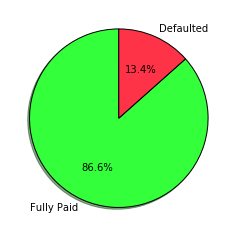

In [29]:
print 'Simple display of the deafult rate for our dataset of 2013 3-year loans:'
defaulted_counts = df['defaulted'].value_counts()

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(111)
ax1.pie([defaulted_counts.iloc[0], defaulted_counts.iloc[1]], 
        labels=['Fully Paid', 'Defaulted'], 
        colors=['#33ff3a','#ff3347'],
        autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()


In [30]:
# Function to encode that categorical predictors
def one_hot(data):
    columnsToEncode = list(data.select_dtypes(include=['category','object']))

    oneHot = pd.get_dummies(data[columnsToEncode])

    # Drop categorical predictors
    data = data.drop(columnsToEncode, axis=1)
    data = data.join(oneHot)
    x = data
    
    return x

In [31]:
# %%time
# Run one hot replacement on categorical predictors
x = one_hot(x_df)

print 'Done with one hot encoding'
print "Num of Predictors:  " + str(x.shape[1])

Done with one hot encoding
Num of Predictors:  150


In [32]:
y = x_df['defaulted'].values

test_ratio = 0.30
x_train, x_test, y_train, y_test = sk_split(x, y, test_size=test_ratio)

np.random.seed(109)
print 'split into train/test sets {:.0f}/{:.0f}, sanity check the train/test row counts'.format(
    (1-test_ratio)*100, test_ratio*100)
print 'x_train: {:,} x_test: {:,}'.format(x_train.shape[0], x_test.shape[0])
print 'y_train: {:,} y_test: {:,}'.format(y_train.size, y_test.size)


split into train/test sets 70/30, sanity check the train/test row counts
x_train: 62,007 x_test: 26,575
y_train: 62,007 y_test: 26,575


In [33]:
# Store the values used for cost analysis
x_train_loan_values = x_train[['loan_amnt', 'total_pymnt', 'default_cost']]
x_test_loan_values = x_test[['loan_amnt', 'total_pymnt', 'default_cost']]

# Drop columns that are most likely populated after the loan is issued.
cols_to_drop = ['issue_d', 'installment', 'default_cost', 'defaulted'               ]

x_train_trimmed = x_train.drop(cols_to_drop, axis=1)
x_test_trimmed = x_test.drop(cols_to_drop, axis=1)

In [34]:
print 'Only 13% of our records winded up in default, meaning this is a rather unbalanced dataset. Let''s make a backup'
print ' dataset that is more evenly weighted between the two default states, by undersampling the rows that are marked'
print ' as Fully Paid.'

# create more balanced datasets, right now only ~13.5% of the rows have defaulted = True
# split train into their component pieces
y_paid = y_train[y_train==0]
y_defaulted = y_train[y_train==1]
x_paid = x_train_trimmed[y_train==0]
x_defaulted = x_train_trimmed[y_train==1]

# random numbers from 0 to 4, length of y_paid
rnd = np.random.choice(5, len(y_paid))
# only keep 20% of the orig fully paid rows
y_paid = y_paid[rnd==0]
x_paid = x_paid[rnd==0]
# confirm the we only have ~20% of orig fully paid row count
# print len(x_train_trimmed[y_train==0]), len(x_paid), len(x_paid)*1.0/len(x_train_trimmed[y_train==0])
print

# take the down-to-20% and add in all the orig defaulted = True rows
y_train_balanced = np.concatenate([y_paid, y_defaulted])
x_train_balanced = np.concatenate([x_paid, x_defaulted])
print '> orig dataset, portion defaulted: {:.2f}%'.format(np.mean(y_train) * 100)
print '> balanced dataset, portion defaulted: {:.2f}%'.format(np.mean(y_train_balanced) * 100)
print '> train observation count has gone down from {:,} to {:,}'.format(len(y_train), len(y_train_balanced))


Only 13% of our records winded up in default, meaning this is a rather unbalanced dataset. Lets make a backup
 dataset that is more evenly weighted between the two default states, by undersampling the rows that are marked
 as Fully Paid.

> orig dataset, portion defaulted: 13.41%
> balanced dataset, portion defaulted: 43.31%
> train observation count has gone down from 62,007 to 19,205


Comparison of our full train dataset vs. the balanced version


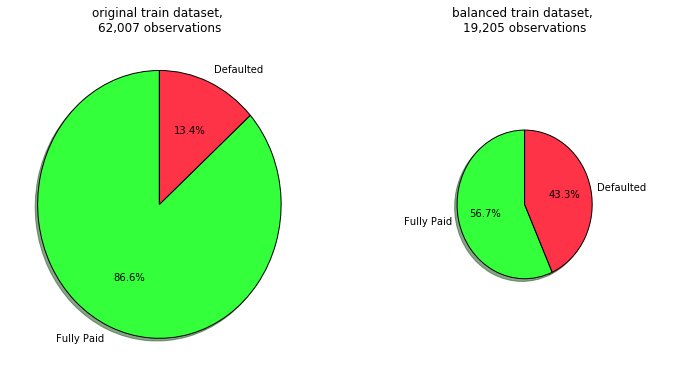

In [35]:
# print [len(y_train[y_train==0]), len(y_train[y_train==1])]
# print [len(y_train_balanced[y_train_balanced==0]), len(y_train_balanced[y_train_balanced==1])]
print 'Comparison of our full train dataset vs. the balanced version'

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title('original train dataset, \n{:,} observations'.format(len(y_train)))
ax1.pie([len(y_train[y_train==0]), len(y_train[y_train==1])], 
        labels=['Fully Paid', 'Defaulted'], 
        colors=['#33ff3a','#ff3347'],
        autopct='%1.1f%%',
        shadow=True, startangle=90)

ax2 = fig.add_subplot(122)
ax2.set_title('balanced train dataset, \n{:,} observations'.format(len(y_train_balanced)))
ax2.pie([len(y_train_balanced[y_train_balanced==0]), len(y_train_balanced[y_train_balanced==1])], 
        labels=['Fully Paid', 'Defaulted'], 
        colors=['#33ff3a','#ff3347'],
        autopct='%1.1f%%',
        radius=0.555,
        shadow=True, startangle=90)

plt.show()




----

## Following section was prepared for previous milestone
#### Needed to come up with some way of measuring the "cost" of default, where almost all loan recipients could be expected to pay back at least part of the loan.

*loan_amnt*  
    - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

*total_pymnt*  
    - Payments received to date for total amount funded  
    total_pymnt = total_rec_prncp+total_rec_int+total_rec_late_fee+recoveries  

*collection_recovery_fee*  
    - post charge off collection fee  
    - definition: Covers costs incurred to collect tax and fee liabilities that are unpaid for more than 90 days.  
     last column in total_pymnt=recoveries, so that must be amnt collection agency brought in, should be subtracted 


#### so the "cost" of a defaulted loan = loan_amnt - total_pymnt - collection_recovery_fee

In [36]:
# best-ish case
# in this scenario, we know who is going to default, and don't lend them anything
# for simplest "best case" we'll assume that money simply sits there without being lent out to some 'other' applicants
# (or otherwise earn any kind of interest etc.)

money_to_loan = np.sum(x_test_loan_values['loan_amnt'])
revenue = np.sum(x_test_loan_values[y_test==0]['total_pymnt'] )
# paid_loans_profit = np.sum(x_test[y_test==0]['total_pymnt'] - x_test[y_test==0]['loan_amnt'])
not_lent = np.sum(x_test_loan_values[y_test==1]['loan_amnt'])
default_revenue = 0
max_net_gain = revenue + not_lent + default_revenue - money_to_loan

print 'Best-ish case, where we know who amongst the screened applicants will default and we don''t loan to them:'
print
print 'money available to lend: {:,.2f}'.format(money_to_loan)
print 'revenue from loans, no defaults: {:,.2f}  not lent (would have defaulted): {:,.2f}'.format(revenue, not_lent)
print '(partial) revenue from loans that wound up defaulting: {:,.2f}'.format(default_revenue)
print 'net gain: ${:,.2f}'.format(max_net_gain)


Best-ish case, where we know who amongst the screened applicants will default and we dont loan to them:

money available to lend: 336,303,525.00
revenue from loans, no defaults: 342,134,025.20  not lent (would have defaulted): 43,126,475.00
(partial) revenue from loans that wound up defaulting: 0.00
net gain: $48,956,975.20


max net gain: $48,956,975.20


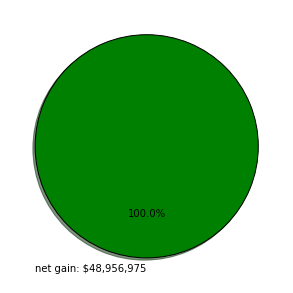

In [37]:

print 'max net gain: ${:,.2f}'.format(max_net_gain)
fig = plt.figure(figsize=(5, 5))

ax1 = fig.add_subplot(111)
ax1.pie([max_net_gain], 
        labels=['net gain: ${:,.0f}'.format(max_net_gain)], 
        colors=['green'],
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

In [38]:
# cost = row['loan_amnt'] - row['total_pymnt'] - row['collection_recovery_fee']

# this is what actually happened..., lent to everyone who passed the loan application process
money_to_loan = np.sum(x_test_loan_values['loan_amnt'])
revenue = np.sum(x_test_loan_values[y_test==0]['total_pymnt'])
not_lent = 0
default_revenue = np.sum(x_test_loan_values['default_cost']) # my default_cost = 0 for all non-defaulters
net_gain = revenue + not_lent + default_revenue - money_to_loan

print 'What actually did happen, Lending Club issued a loan to everyone who passed their application screening'
print
print 'money available to lend: {:,.2f}'.format(money_to_loan)
print 'revenue from loans: {:,.2f}  not lent to anyone: {:,.2f}'.format(revenue, not_lent)
print '(partial) revenue from loans that wound up defaulting: {:,.2f}'.format(default_revenue)
print 'net gain: ${:,.2f}'.format(net_gain)


What actually did happen, Lending Club issued a loan to everyone who passed their application screening

money available to lend: 336,303,525.00
revenue from loans: 342,134,025.20  not lent to anyone: 0.00
(partial) revenue from loans that wound up defaulting: 15,787,668.43
net gain: $21,618,168.63


actual net gain: $21,618,168.63


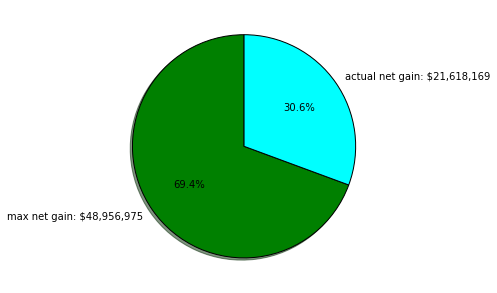

In [39]:
print 'actual net gain: ${:,.2f}'.format(net_gain)
fig = plt.figure(figsize=(5, 5))

ax1 = fig.add_subplot(111)
ax1.pie([max_net_gain, net_gain], 
        labels=['max net gain: ${:,.0f}'.format(max_net_gain),'actual net gain: ${:,.0f}'.format(net_gain)], 
        colors=['green', 'cyan'],
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

In [40]:
# figure out the default rate based off of entire dataset
defaults = float(df['defaulted'].sum())
tot_loans = float(df.shape[0])
print "Number of Defaults:  "  + str(defaults)
print "Number of Loans:     "  + str(tot_loans)
print "Percent of Default:  "  + str(defaults / tot_loans * 100)


Number of Defaults:  11898.0
Number of Loans:     88582.0
Percent of Default:  13.4316226773


In [41]:
# OCG, setting a random seed
np.random.seed(109)

# using test set, randomly genrate a default rate of ~ 13.5%
defaults = float(y_test.sum())
tot_loans = float(y_test.shape[0])

# Get random answers
randoms = np.zeros(int(tot_loans))
pct_def = defaults / tot_loans
i = 0
for r in randoms:
    rr = randoms[i]
    rand = np.random.random_sample()
    if rand < pct_def:
        randoms[i] = 1
        i = i+1

print 'Set observations to randomly default at same rate as the full dataset.'
print
print 'Equivalent default rate via random generation: {:.2f}%'.format(np.mean(randoms) * 100)
print "Estimated Defaults:  {:,.0f} out of {:,.0f}".format(randoms.sum(), randoms.shape[0])
print 'Number of loans to issue, to those we believe wont''nt default: {:,.0f}'.format(randoms.shape[0] - randoms.sum())

Set observations to randomly default at same rate as the full dataset.

Equivalent default rate via random generation: 13.69%
Estimated Defaults:  3,639 out of 26,575
Number of loans to issue, to those we believe wontnt default: 22,936


In [42]:
# ok, now we have a list of 3,657 the random model has said will default

money_to_loan = np.sum(x_test_loan_values['loan_amnt'])
# they would not have defaulted (y_test=0) and we did lend to them (randoms=0, random model predicted they would not default)
revenue = np.sum(x_test_loan_values[(y_test==0) & (randoms==0)]['total_pymnt'])
# don't lend anything to those 3,657 people we believe are going to default
not_lent = np.sum(x_test_loan_values[randoms==1]['loan_amnt'])
# we'll be wrong on some of those 22,918 loans and they will default
# my default_cost = 0 for all non-defaulters, so simply sum that field for everyone we did lend to
default_revenue = np.sum(x_test_loan_values[randoms==0]['default_cost']) 
net_gain = revenue + not_lent + default_revenue - money_to_loan

print 'Randomly estimate who will default and do not lend to them'
print 'Money available to lend:                               {:,.2f}'.format(money_to_loan)
print '    Revenue from loans:                                {:,.2f}'.format(revenue)
print '    Not lent to anyone:                                {:,.2f}'.format(not_lent)
print '(Partial) revenue from loans that wound up defaulting: {:,.2f}'.format(default_revenue)

print 'Net Gain:                                             ${:,.2f}'.format(net_gain)

Randomly estimate who will default and do not lend to them
Money available to lend:                               336,303,525.00
    Revenue from loans:                                295,825,257.52
    Not lent to anyone:                                46,007,100.00
(Partial) revenue from loans that wound up defaulting: 13,522,661.89
Net Gain:                                             $19,051,494.41


random baseline net gain: $19,051,494.41


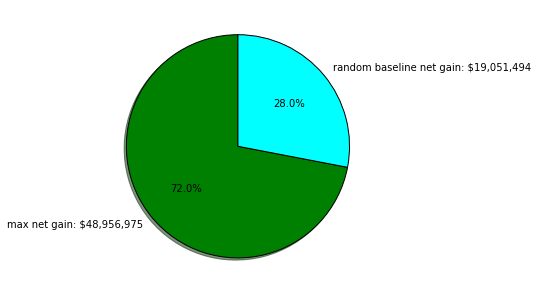

In [43]:
print 'random baseline net gain: ${:,.2f}'.format(net_gain)
fig = plt.figure(figsize=(5, 5))

ax1 = fig.add_subplot(111)
ax1.pie([max_net_gain, net_gain], 
        labels=['max net gain: ${:,.0f}'.format(max_net_gain),'random baseline net gain: ${:,.0f}'.format(net_gain)], 
        colors=['green', 'cyan'],
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

In [44]:
# function to measure profit
def profit_calc(x_vals, y_vals, preds):
    money_to_loan = np.sum(x_vals['loan_amnt'])

    # they would not have defaulted (y_test=0) and we 
    # did lend to them (preds=0, model predicted 
    # they would not default)
    revenue = np.sum(x_vals[(y_vals==0) & (preds==0)]['total_pymnt'])
    
    # don't lend anything to those people we believe are going to default
    not_lent = np.sum(x_vals[preds==1]['loan_amnt'])
    
    # we'll be wrong on some of those 22,918 loans and they will default
    # my default_cost = 0 for all non-defaulters, so simply sum that 
    # field for everyone we did lend to
    default_revenue = np.sum(x_vals[preds==0]['default_cost']) 
    net_gain = revenue + not_lent + default_revenue - money_to_loan
    
    return money_to_loan, revenue, not_lent, default_revenue, net_gain

In [45]:
# function to print out profit results of a given model's predictions
def how_do_we_look(x_vals, y_vals, preds):
    money_to_loan, revenue, not_lent, default_revenue, net_gain = profit_calc(x_vals, y_vals, preds)
    
    print 'Estimate who will default and don''t lend to them'
    print 'Money available to lend:                               {:,.2f}'.format(money_to_loan)
    print '    Revenue from loans:                                {:,.2f}'.format(revenue)
    print '    Not lent to anyone:                                {:,.2f}'.format(not_lent)
    print '(Partial) revenue from loans that wound up defaulting: {:,.2f}'.format(default_revenue)
    
    print 'Net Gain:                                             ${:,.2f}'.format(net_gain)


----

### And now off to the modeling races...

In [46]:
%%time
#SPD
# Random Forest
from sklearn.ensemble import RandomForestClassifier

feats = []

feats.append(1)
feats.append(3)
feats.append(5)
feats.append(10)
feats.append(20)
feats.append(int(x_train_trimmed.shape[1] * 0.3))
feats.append(int(x_train_trimmed.shape[1] * 0.35))
feats.append(int(x_train_trimmed.shape[1] * 0.4))
feats.append(int(x_train_trimmed.shape[1] * 0.45))

scores = []
preds = []
for f in feats:
    print f # progress check
    clf = RandomForestClassifier(n_estimators=100,
                                 max_features=f,
                                 max_depth=None,
                                 min_samples_split=2,
                                 oob_score=True)
    clf = clf.fit(x_train_trimmed, y_train)

    forest_pred = clf.predict(x_test_trimmed)
        
    scores.append(str(np.mean(forest_pred == y_test)))
    
    preds.append(forest_pred)
    
print 


1
3
5
10
20
43
51
58
65

Wall time: 16min 18s


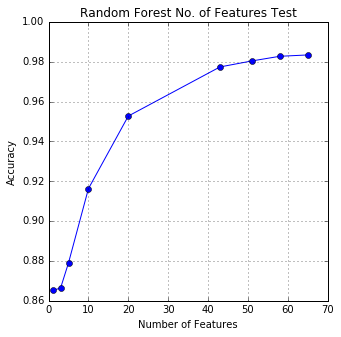

In [47]:
#SPD
fig = plt.figure(figsize=[5,5])

ax = fig.add_subplot(111)

ax.plot(feats, scores, marker="o")

ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Random Forest No. of Features Test")
plt.grid()

### Random Forest Observations


In [48]:
#SPD
index_of_rf = 5
num_of_features = feats[index_of_rf]
print "The accuracy graphs have shown that using " + str(num_of_features) + " features yields the highest scores before it "
print "starts to plateau.  If we were to just pick the highest yielding score, we would risk "
print "over-fitting the data."
print
print "Score sklearn RandomForestClassifier:  " +  str(scores[index_of_rf])
how_do_we_look(x_test_loan_values, y_test, preds[index_of_rf])
print

forest_pred = preds[index_of_rf]

The accuracy graphs have shown that using 43 features yields the highest scores before it 
starts to plateau.  If we were to just pick the highest yielding score, we would risk 
over-fitting the data.

Score sklearn RandomForestClassifier:  0.977347130762
Estimate who will default and dont lend to them
Money available to lend:                               336,303,525.00
    Revenue from loans:                                342,057,603.52
    Not lent to anyone:                                35,702,600.00
(Partial) revenue from loans that wound up defaulting: -78,134.05
Net Gain:                                             $41,378,544.48



#### SVM Note:
Generating an SVM model proved too great of a challenge for the limited computing power available to us.

In [49]:
# SVM - Currently taking too long
# model = svm.SVC(C=1, kernel='linear', degree=2)
# model.fit(X_train, y_train)


In [50]:
%%time
#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()
logreg.fit(x_train_trimmed, y_train)
log_reg_pred = logreg.predict(x_test_trimmed)

how_do_we_look(x_test_loan_values, y_test, log_reg_pred)

print
print 'Logistic Regression'
print 'Accuracy on overall test set:', logreg.score(x_test_trimmed, y_test)
print 'Accuracy on No Default (Fully Paid) in test set:', logreg.score(x_test_trimmed[y_test == 0], y_test[y_test == 0])
print 'Accuracy on Defaulted in test set:', logreg.score(x_test_trimmed[y_test == 1], y_test[y_test == 1])


Estimate who will default and dont lend to them
Money available to lend:                               336,303,525.00
    Revenue from loans:                                342,134,025.20
    Not lent to anyone:                                35,840,175.00
(Partial) revenue from loans that wound up defaulting: -60,087.08
Net Gain:                                             $41,610,588.13

Logistic Regression
Accuracy on overall test set: 0.969971777987
Accuracy on No Default (Fully Paid) in test set: 1.0
Accuracy on Defaulted in test set: 0.777157218654
Wall time: 21.8 s


In [51]:
%%time
# 12/8 ocg new, should be equivalent of below, well not as good, but I think is a good illustration
logreg_balanced = linear_model.LogisticRegression()
logreg_balanced.fit(x_train_balanced, y_train_balanced)
log_reg_pred_balanced = logreg_balanced.predict(x_test_trimmed)

how_do_we_look(x_test_loan_values, y_test, log_reg_pred_balanced)

print
print 'Logistic Regression, using balanced dataset (undersampling on Fully Paid)'
print 'Accuracy on overall test set:', logreg_balanced.score(x_test_trimmed, y_test)
print 'Accuracy on No Default (Fully Paid) in test set:', logreg_balanced.score(x_test_trimmed[y_test == 0], y_test[y_test == 0])
print 'Accuracy on Defaulted in test set:', logreg_balanced.score(x_test_trimmed[y_test == 1], y_test[y_test == 1])


Estimate who will default and dont lend to them
Money available to lend:                               336,303,525.00
    Revenue from loans:                                335,659,139.93
    Not lent to anyone:                                46,549,625.00
(Partial) revenue from loans that wound up defaulting: -331,866.63
Net Gain:                                             $45,573,373.30

Logistic Regression, using balanced dataset (undersampling on Fully Paid)
Accuracy on overall test set: 0.97429915334
Accuracy on No Default (Fully Paid) in test set: 0.983256501696
Accuracy on Defaulted in test set: 0.916783021502
Wall time: 5.7 s


In [52]:
# with default, regularization=L2, solver=liblinear
logreg_weighted = linear_model.LogisticRegression(class_weight='balanced')
logreg_weighted.fit(x_train_trimmed, y_train)
logreg_weighted_pred = logreg_weighted.predict(x_test_trimmed)

how_do_we_look(x_test_loan_values, y_test, logreg_weighted_pred)

print 'Weighted Logistic Regression: L2 regularization, liblinear solver'
print 'Accuracy on overall test set:', logreg_weighted.score(x_test_trimmed, y_test)
print 'Accuracy on No Default (Fully Paid) in test set:', logreg_weighted.score(x_test_trimmed[y_test == 0], y_test[y_test == 0])
print 'Accuracy on Defaulted in test set:', logreg_weighted.score(x_test_trimmed[y_test == 1], y_test[y_test == 1])
print 
print 'Compared to the basic logistic regression model, overall accuracy in both "weighted" and'
print ' balanced variants went down a bit, as did No Default accuracy, but Defaulted accuracy'
print ' increased quite a bit'

Estimate who will default and dont lend to them
Money available to lend:                               336,303,525.00
    Revenue from loans:                                333,697,365.49
    Not lent to anyone:                                48,724,575.00
(Partial) revenue from loans that wound up defaulting: -322,584.22
Net Gain:                                             $45,795,831.26
Weighted Logistic Regression: L2 regularization, liblinear solver
Accuracy on overall test set: 0.969369708373
Accuracy on No Default (Fully Paid) in test set: 0.975819779073
Accuracy on Defaulted in test set: 0.92795308573

Compared to the basic logistic regression model, overall accuracy in both "weighted" and
 balanced variants went down a bit, as did No Default accuracy, but Defaulted accuracy
 increased quite a bit


**Note:** Random Forest and Weighted LogisticRegression were looking best for us, so it made sense to try a few variations off of that base to see if changing some parameters (solver & regularization/penalty type) would help. Different C values will be used at a later step.

In [53]:
# l1 regularization, default solver (liblinear)
logreg_weighted = linear_model.LogisticRegression(
    class_weight='balanced',
    penalty='l1')
logreg_weighted.fit(x_train_trimmed, y_train)
logreg_weighted_pred1 = logreg_weighted.predict(x_test_trimmed)

how_do_we_look(x_test_loan_values, y_test, logreg_weighted_pred1)

print 'Weighted Logistic Regression: L1 regularization, liblinear solver'
print 'Accuracy on overall test set:', logreg_weighted.score(x_test_trimmed, y_test)
print 'Accuracy on No Default (Fully Paid) in test set:', logreg_weighted.score(x_test_trimmed[y_test == 0], y_test[y_test == 0])
print 'Accuracy on Defaulted in test set:', logreg_weighted.score(x_test_trimmed[y_test == 1], y_test[y_test == 1])

Estimate who will default and dont lend to them
Money available to lend:                               336,303,525.00
    Revenue from loans:                                333,007,462.21
    Not lent to anyone:                                49,655,575.00
(Partial) revenue from loans that wound up defaulting: -281,655.97
Net Gain:                                             $46,077,856.24
Weighted Logistic Regression: L1 regularization, liblinear solver
Accuracy on overall test set: 0.96549388523
Accuracy on No Default (Fully Paid) in test set: 0.969470296599
Accuracy on Defaulted in test set: 0.939960904775


In [54]:
# l2 regularization, solver = lbfgs
logreg_weighted = linear_model.LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='lbfgs')
logreg_weighted.fit(x_train_trimmed, y_train)
logreg_weighted_pred2 = logreg_weighted.predict(x_test_trimmed)

how_do_we_look(x_test_loan_values, y_test, logreg_weighted_pred2)

print 'Weighted Logistic Regression: L2 regularization, lbfgs solver'
print 'Accuracy on overall test set:', logreg_weighted.score(x_test_trimmed, y_test)
print 'Accuracy on No Default (Fully Paid) in test set:', logreg_weighted.score(x_test_trimmed[y_test == 0], y_test[y_test == 0])
print 'Accuracy on Defaulted in test set:', logreg_weighted.score(x_test_trimmed[y_test == 1], y_test[y_test == 1])

Estimate who will default and dont lend to them
Money available to lend:                               336,303,525.00
    Revenue from loans:                                325,345,331.16
    Not lent to anyone:                                51,450,700.00
(Partial) revenue from loans that wound up defaulting: -66,720.11
Net Gain:                                             $40,425,786.05
Weighted Logistic Regression: L2 regularization, lbfgs solver
Accuracy on overall test set: 0.898626528692
Accuracy on No Default (Fully Paid) in test set: 0.905714534226
Accuracy on Defaulted in test set: 0.853113655404


In [55]:
# l2 regularization, solver = 'sag' instead of default liblinear
# print, warning 
logreg_weighted = linear_model.LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    max_iter=300,   #at default 100, warning re "the coef_ did not converge" and poor accuracy, 300 worked in at least one test
    solver='sag')
logreg_weighted.fit(x_train_trimmed, y_train)
logreg_weighted_pred3 = logreg_weighted.predict(x_test_trimmed)

how_do_we_look(x_test_loan_values, y_test, logreg_weighted_pred3)

print 'Weighted Logistic Regression: L2 regularization, sag solver'
print 'Accuracy on overall test set:', logreg_weighted.score(x_test_trimmed, y_test)
print 'Accuracy on No Default (Fully Paid) in test set:', logreg_weighted.score(x_test_trimmed[y_test == 0], y_test[y_test == 0])
print 'Accuracy on Defaulted in test set:', logreg_weighted.score(x_test_trimmed[y_test == 1], y_test[y_test == 1])


Estimate who will default and dont lend to them
Money available to lend:                               336,303,525.00
    Revenue from loans:                                333,747,355.49
    Not lent to anyone:                                43,245,625.00
(Partial) revenue from loans that wound up defaulting: 31,932.96
Net Gain:                                             $40,721,388.45
Weighted Logistic Regression: L2 regularization, sag solver
Accuracy on overall test set: 0.919247412982
Accuracy on No Default (Fully Paid) in test set: 0.931068974515
Accuracy on Defaulted in test set: 0.843339849204


C:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The best models would appear to both use the default liblinear solver, with L1/lasso & L2/ridge both showing similar outputs.

#### Logistic Regression CV Note: 
It would have been nice to run the LogisticRegressionCV on the full train dataset and using class_weight='balanced', but this was another case where the compuation was taking too long. So a couple of cells below is the LogisticRegressionCV run on the smaller balanced dataset we had created earlier, without passing in any class_weight parameter.

In [56]:
# the version that should be run but class_weight='balanced' is taking an inordinate amount of time to complete

# %%time
#
#from sklearn.linear_model import LogisticRegressionCV as LogRegCV
#
##Generate array of regularization parameters
#regularization = 10.**np.arange(-3, 4)
#
##Fit logistic model with cross validation to select the optimal regularization parameter
#logreg_cv = LogRegCV(cv=5, 
#                    penalty='l1', 
#                    Cs=regularization, 
#                    solver='liblinear', 
#                    class_weight='balanced', #'balanced' here is taking wayyyy too long
#                    n_jobs=-1)
#logreg_cv.fit(x_train_trimmed, y_train)
##logreg_cv.fit(x_train_balanced, y_train)   # balanced data set
#logreg_cv_pred = logreg_cv.predict(x_test_trimmed)
#
#how_do_we_look(x_test_loan_values, y_test, logreg_cv_pred)
#
#
#print 'Accuracy on overall test set:', logreg_cv.score(x_test_trimmed, y_test)
#print 'Accuracy on No Default (Fully Paid) in test set:', logreg_cv.score(x_test_trimmed[y_test == 0], y_test[y_test == 0])
#print 'Accuracy on Defaulted in test set:', logreg_cv.score(x_test_trimmed[y_test == 1], y_test[y_test == 1])
#

In [57]:
%%time

# the version using the balanced data set

from sklearn.linear_model import LogisticRegressionCV as LogRegCV

#Generate array of regularization parameters
regularization = 10.**np.arange(-3, 4)

#Fit logistic model with cross validation to select the optimal regularization parameter
logreg_cv = LogRegCV(cv=5, 
                    penalty='l1', 
                    Cs=regularization, 
                    solver='liblinear', 
                    n_jobs=-1)
# x_train_balanced here:
logreg_cv.fit(x_train_balanced, y_train_balanced)
logreg_cv_pred = logreg_cv.predict(x_test_trimmed)

how_do_we_look(x_test_loan_values, y_test, logreg_cv_pred)


print 'Accuracy on overall test set:', logreg_cv.score(x_test_trimmed, y_test)
print 'Accuracy on No Default (Fully Paid) in test set:', logreg_cv.score(x_test_trimmed[y_test == 0], y_test[y_test == 0])
print 'Accuracy on Defaulted in test set:', logreg_cv.score(x_test_trimmed[y_test == 1], y_test[y_test == 1])


Estimate who will default and dont lend to them
Money available to lend:                               336,303,525.00
    Revenue from loans:                                335,281,457.04
    Not lent to anyone:                                47,342,850.00
(Partial) revenue from loans that wound up defaulting: -296,148.57
Net Gain:                                             $46,024,633.47
Accuracy on overall test set: 0.972681091251
Accuracy on No Default (Fully Paid) in test set: 0.978516134644
Accuracy on Defaulted in test set: 0.935213627478
Wall time: 2min 46s


In [58]:
print 'A real quick set of LDA & QDA models, though we didn''t wind up exploring too much.'
#LDA

lda = LDA()
lda.fit(x_train_trimmed, y_train)

print 'LDA Score, orig dataset:  ' + str(lda.score(x_test_trimmed, y_test))

#QDA
qda = QDA()
qda.fit(x_train_trimmed, y_train)

print 'QDA Score, orig dataset:  ' + str(qda.score(x_test_trimmed, y_test))

A real quick set of LDA & QDA models, though we didnt wind up exploring too much.
LDA Score, orig dataset:  0.94780809031

C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



QDA Score, orig dataset:  0.855653809972


In [59]:
#same as above but train on the balanced datasets

#LDA
lda = LDA()
lda.fit(x_train_balanced, y_train_balanced)

print 'LDA Score, balanced dataset:  ' + str(lda.score(x_test_trimmed, y_test))

#QDA
qda = QDA()
qda.fit(x_train_balanced, y_train_balanced)

print 'QDA Score, balanced dataset:  ' + str(qda.score(x_test_trimmed, y_test))

LDA Score, balanced dataset:  0.960150517404
QDA Score, balanced dataset:  0.861298212606


In [60]:
# Function to plot the confusion matrix
def plot_confusion_matrix(confusion, ax,title='Confusion matrix',cmap=plt.cm.gray_r):
    
    tot = float(confusion[0,0] + confusion[0,1] + confusion[1,0] + confusion[1,1])
 
    conf = np.empty([2,2])
     
    conf[0,0] = float(confusion[0,0]) / tot
    conf[0,1] = float(confusion[0,1]) / tot
    conf[1,0] = float(confusion[1,0]) / tot
    conf[1,1] = float(confusion[1,1]) / tot

    cax = ax.matshow(conf, cmap=cmap) # imshow
    ax.set_title(title)
    fig.colorbar(cax)
    tick_marks = np.arange(len(conf[0]))
    plt.xticks(tick_marks)
    plt.yticks(tick_marks )
    
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

    return ax
    

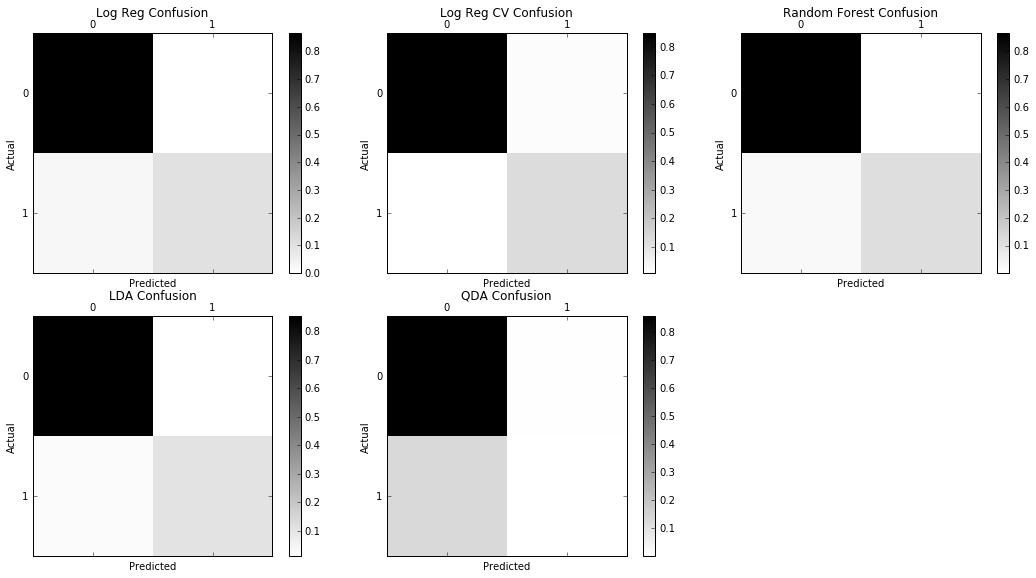

In [61]:
# Create the confusion matrix 
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(231)
log_reg_conf = confusion_matrix(y_test, log_reg_pred)
plot_confusion_matrix(log_reg_conf, ax, "Log Reg Confusion")


ax2 = fig.add_subplot(232)
logreg_cv_pred = logreg_cv.predict(x_test_trimmed)
logreg_cv_conf = confusion_matrix(y_test, logreg_cv_pred)
plot_confusion_matrix(logreg_cv_conf, ax2, "Log Reg CV Confusion")

ax3 = fig.add_subplot(233)
forest_conf = confusion_matrix(y_test, forest_pred)
plot_confusion_matrix(forest_conf, ax3, "Random Forest Confusion")

ax4 = fig.add_subplot(234)
lda_pred = lda.predict(x_test_trimmed)
lda_conf = confusion_matrix(y_test, lda_pred)
plot_confusion_matrix(lda_conf, ax4, "LDA Confusion")

ax5 = fig.add_subplot(235)
qda_pred = qda.predict(x_test_trimmed)
qda_conf = confusion_matrix(y_test, qda_pred)
plot_confusion_matrix(qda_conf, ax5, "QDA Confusion")


plt.tight_layout()
plt.show()

#print log_reg_conf
#print logreg_cv_conf
#print forest_conf

In [62]:
def plot_roc(fpr, tpr, title, roc_auc, ax):
    ax.set_title(title)
    ax.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    ax.legend(loc='lower right')
    ax.plot([0,1],[0,1],'r--')
    ax.set_xlim([-0.1,1.2])
    ax.set_ylim([-0.1,1.2])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    
    return ax

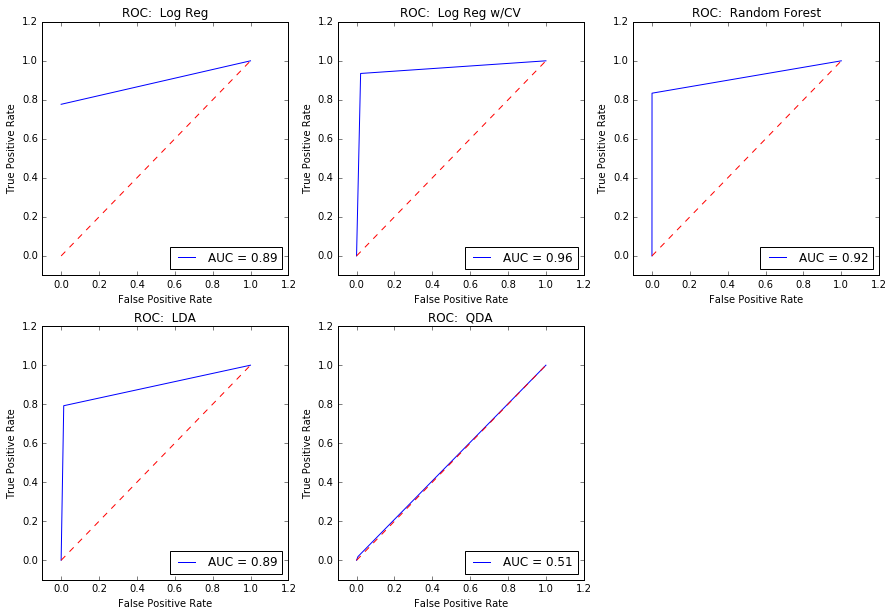

In [63]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=[15,10])

# ROC for Log Reg
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, log_reg_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

ax = fig.add_subplot(231)
plot_roc(false_positive_rate, true_positive_rate, "ROC:  Log Reg", roc_auc, ax)

# ROC for Log Reg w/CV
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, logreg_cv_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

ax2 = fig.add_subplot(232)
plot_roc(false_positive_rate, true_positive_rate, "ROC:  Log Reg w/CV", roc_auc, ax2)

# ROC for Random Forest
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

ax3 = fig.add_subplot(233)
plot_roc(false_positive_rate, true_positive_rate, "ROC:  Random Forest", roc_auc, ax3)

# ROC for LDA
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, lda_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

ax4 = fig.add_subplot(234)
plot_roc(false_positive_rate, true_positive_rate, "ROC:  LDA", roc_auc, ax4)

# ROC for QDA
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, qda_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

ax5 = fig.add_subplot(235)
plot_roc(false_positive_rate, true_positive_rate, "ROC:  QDA", roc_auc, ax5)
plt.show()